In [1]:
import numpy
import random
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import datetime
import cartopy.crs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from PIL import Image
import pandas
from sklearn.linear_model import LinearRegression, LogisticRegression
from mpl_toolkits.mplot3d import Axes3D
import seaborn
import scipy
from scipy import stats
from scipy.stats import poisson, ttest_ind
from scipy import linalg
import xarray as xr
import netCDF4
import cftime
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define Directory
Diri = "data/orig/"

#
# Define Variables of Research
# Near Surface Air Temperature
Var1 = "tas"
Temp_Files = os.listdir(Diri+Var1+"/global/")
# Net Radiative Flux at Top of Atmosphere
Var2 = "netTOA"
Net_TOA_Files = os.listdir(Diri+Var2+"/global/")
# Precipitation
Var3 = "pr"
Precip_Files = os.listdir(Diri+Var3+"/global/")

In [3]:
# Open Temperature Files
for File in Temp_Files:
    Parts = File.split("_")
    Model = Parts[1]
    Experiment = Parts[2]
    Time = Parts[3].split(".")[0]
    if Time=="150":
        Temp_Files.remove(File)

In [4]:
# List and Open Net Top of Atmosphere Radiation Files
for File in Net_TOA_Files: 
#    print(File)
    Parts = File.split("_")
    Model = Parts[1]
    Experiment = Parts[2]
    Time = Parts[3].split(".")[0]
#    print(Time)
    if Time=="150":
#        print("Remove model")
        Net_TOA_Files.remove(File)

In [5]:
# Open Precipitation Files
for File in Precip_Files:
    Parts = File.split("_")
    Model = Parts[1]
    Experiment = Parts[2]
    Time = Parts[3].split(".")[0]
    if Time=="150":
        Precip_Files.remove(File)

In [6]:
# Create Pertubations Library
Perturbations = {} 
for File in Temp_Files: 
    Parts = File.split("_")
    Model = Parts[1]
    Experiment = Parts[2]
    if Experiment!="control": 
        if Model in list(Perturbations):
            Perturbations[Model].append(Experiment)
        else:
            Perturbations[Model] = [Experiment]
print (Perturbations)

{'MPIESM12': ['abrupt4x'], 'GISSE2R': ['abrupt4x'], 'IPSLCM5A': ['abrupt4x'], 'CCSM3': ['abrupt4x'], 'HadGEM2': ['abrupt4x'], 'CESM104': ['abrupt4x'], 'CCSM3II': ['abrupt1400ppm'], 'ECHAM5MPIOM': ['abrupt4x'], 'FAMOUS': ['abrupt4x'], 'CNRMCM61': ['abrupt4x'], 'HadCM3L': ['abrupt4x'], 'MPIESM11': ['abrupt4x']}


In [7]:
# Create Abrupt 4x Pertubations Library
Pert_4x = {}
for File in Temp_Files: 
    Parts = File.split("_")
    Model = Parts[1]
    Experiment = Parts[2]
    if Experiment!="control": 
        if Experiment=="abrupt4x" or Experiment=="abrupt1400ppm":
            Pert_4x[Model] = Experiment
print (Pert_4x)
#
# Define Number of Datasets
Num_Datasets = len(Pert_4x)
print (Num_Datasets)

{'MPIESM12': 'abrupt4x', 'GISSE2R': 'abrupt4x', 'IPSLCM5A': 'abrupt4x', 'CCSM3': 'abrupt4x', 'HadGEM2': 'abrupt4x', 'CESM104': 'abrupt4x', 'CCSM3II': 'abrupt1400ppm', 'ECHAM5MPIOM': 'abrupt4x', 'FAMOUS': 'abrupt4x', 'CNRMCM61': 'abrupt4x', 'HadCM3L': 'abrupt4x', 'MPIESM11': 'abrupt4x'}
12


In [8]:
# Create List of Models
#Model_List = []
#for Model in list(Pert_4x):
#    Model_List.append(Model)
Model_List = ['MPIESM12', 'MPIESM11', 'IPSLCM5A', 'HadGEM2', 'HadCM3L', 'GISSE2R', 'FAMOUS', 'ECHAM5MPIOM', \
'CNRMCM61', 'CESM104', 'CCSM3II', 'CCSM3']
print (Model_List)

['MPIESM12', 'MPIESM11', 'IPSLCM5A', 'HadGEM2', 'HadCM3L', 'GISSE2R', 'FAMOUS', 'ECHAM5MPIOM', 'CNRMCM61', 'CESM104', 'CCSM3II', 'CCSM3']


In [9]:
# Create Function to Open Temperature Files
def Open_Temp_Files(Temp_Files, Model):
# Open Temperature Control Files
    Temp_Control_Filename = [i for i in Temp_Files if i.startswith("tas_"+Model+"_"+"control"+"_")][0]
    Temp_Control_Data = xr.open_dataset(Diri+"tas/global/"+Temp_Control_Filename)
    Temp_Control = Temp_Control_Data.tas
    Years_Control = range(len(Temp_Control))
#
# Open Temperature 4x Files
    Temp_4x_Filename = [i for i in Temp_Files if i.startswith("tas_"+Model+"_"+Pert_4x[Model]+"_")][0]
    Temp_4x_Data = xr.open_dataset(Diri+"tas/global/"+Temp_4x_Filename)
    Temp_4x = Temp_4x_Data.tas
    Years_4x = range(len(Temp_4x))
#
# Return Results
    return (Temp_Control, Years_Control, Temp_4x, Years_4x)

In [10]:
# Create Function to Create Smoothen Temperature 4x and Control Lines
def Temp_Smooth(Temp_Control, Years_Control, Temp_4x, Years_4x, Model):
### Take the difference of each time step to the time-averaged control simulation imbalance
    Temp_Control_Smooth = Temp_Control.mean() + Temp_4x*0
#
# Return Results
    return (Temp_Control_Smooth)

In [11]:
# Create Function to Open Net TOA Files
def Open_Net_TOA_Files(Net_TOA_Files, Model):
# Open Net TOA Control Files
    Net_TOA_Control_Filename = [i for i in Net_TOA_Files if i.startswith("netTOA_"+Model+"_"+"control"+"_")][0]
    Net_TOA_Control_Data = xr.open_dataset(Diri+"netTOA/global/"+Net_TOA_Control_Filename)
    Net_TOA_Control_Data["netTOA"][Net_TOA_Control_Data["netTOA"] < 0] = numpy.nan
    Net_TOA_Control = Net_TOA_Control_Data.netTOA
    Net_TOA_Control[Net_TOA_Control < 0] = numpy.nan
    Years_Control = range(len(Net_TOA_Control))
    Years_Control = numpy.array(Years_Control)
#
# Open Net TOA 4x Files
    Net_TOA_4x_Filename = [i for i in Net_TOA_Files if i.startswith("netTOA_"+Model+"_"+Pert_4x[Model]+"_")][0]
    Net_TOA_4x_Data = xr.open_dataset(Diri+"netTOA/global/"+Net_TOA_4x_Filename)
    Net_TOA_4x = Net_TOA_4x_Data.netTOA
    Years_4x = range(len(Net_TOA_4x))
#
# Return Results
    return (Net_TOA_Control, Years_Control, Net_TOA_4x, Years_4x)

In [12]:
# Create Function to Create Smoothen Net TOA 4x and Control Lines
def Net_TOA_Smooth(Net_TOA_Control, Years_Control, Net_TOA_4x, Years_4x, Model):
### Atmospheric variable anomal - removing imbalances in the control and drift
### (Rugenstein et al 2019, BAMS - section 3a, fig 3)
### Take the difference of each time step to the time-averaged control simulation imbalance
    Net_TOA_Control_Smooth = Net_TOA_Control.mean() + Net_TOA_4x*0
#
# Return Results
    return (Net_TOA_Control_Smooth)

In [13]:
# Create Function to Open Precipitation Files
def Open_Precip_Files(Precip_Files, Model):
# Open Precipitation Control Files
    Precip_Control_Filename = [i for i in Precip_Files if i.startswith("pr_"+Model+"_"+"control"+"_")][0]
    Precip_Control_Data = xr.open_dataset(Diri+"pr/global/"+Precip_Control_Filename)
    Precip_Control_Data["pr"][Precip_Control_Data["pr"] < 0] = numpy.nan
    Precip_Control = Precip_Control_Data.pr
    Precip_Control[Precip_Control < 0] = numpy.nan
    Years_Control = range(len(Precip_Control))
#
# Open Precipitation 4x Files
    Precip_4x_Filename = [i for i in Precip_Files if i.startswith("pr_"+Model+"_"+Pert_4x[Model]+"_")][0]
    Precip_4x_Data = xr.open_dataset(Diri+"pr/global/"+Precip_4x_Filename)
    Precip_4x = Precip_4x_Data.pr
    Years_4x = range(len(Precip_4x))
#
# Return Results
    return (Precip_Control, Years_Control, Precip_4x, Years_4x)

In [14]:
# Create Function to Create Smoothen Precipitation 4x and Control Lines
L_Vapour = 2.5 * 10**6
def Precip_Smooth(Precip_Control, Years_Control, Precip_4x, Years_4x, Model):
### Atmospheric variable anomal - removing imbalances in the control and drift
### (Rugenstein et al 2019, BAMS - section 3a, fig 3)
### Take the difference of each time step to the time-averaged control simulation imbalance
    Precip_Control_Smooth = Precip_Control.mean() + Precip_4x*0
#
# Return Results
    return (Precip_Control_Smooth)

## New York Method Regression

In [15]:
def AutocorLone(x):
    a = numpy.ma.masked_invalid(x[:-1])
    b = numpy.ma.masked_invalid(x[1:])
    msk = (~a.mask & ~b.mask)
    ac = numpy.ma.corrcoef(a[msk],b[msk])[0,1]
    #print(ac)
    return ac

In [16]:
def Detrend(x):
    xc = x - x.mean()
    t = numpy.arange(len(x))
    tc = t - t.mean()
    slope, intercept, r_value, p_value, std_err = stats.linregress(tc,xc)
### Maybe I need to include the intercept here if it's nonzero? 
    xdc = xc - slope*tc
    return xdc

In [17]:
def Corr_IgnoreNaN(x,y):
    a = numpy.ma.masked_invalid(x)
    b = numpy.ma.masked_invalid(y)
    msk = (~a.mask & ~b.mask)
    c = numpy.ma.corrcoef(a[msk],b[msk])[0,1]
    #print(ac)
    return c

In [18]:
def CalcParams_Fixed_iv(xdat,sxi,ydat,syi,pit):
    """
    Calculate the parameters, both intercepts as well as the slope of the regression
    :return:
    """
    # backwards compatibility with calcparams

    [sxi,syi,pit]=Backwards_Compat(sxi,syi,pit)

        
    xbar = xdat.mean()
    ybar = ydat.mean()

    xp = xdat-xbar
    yp = ydat-ybar

    sum_xp2 = numpy.sum(xp*xp)
    sum_yp2 = numpy.sum(yp*yp)
    sum_xpyp = numpy.sum(xp*yp)

    c1 = pit*sxi*syi*sum_xp2 - numpy.power(sxi,2)*sum_xpyp
    c2 = - numpy.power(syi,2)*sum_xp2 + numpy.power(sxi,2)*sum_yp2
    c3 = numpy.power(syi,2)*sum_xpyp - pit*sxi*syi*sum_yp2
    
    ## negative root
    bcalc = (-c2 - numpy.sqrt(numpy.power(c2,2)-4*c1*c3)) / 2 / c1 
    #balt = (-c2 + numpy.sqrt(numpy.power(c2,2)-4*c1*c3)) / 2 / c1 ### positive root appears to be unumpyhysical

    # now that slope is determined, calculate the y intercept
    yinter = ybar - bcalc * xbar

    # now done, so write back slope
    slope = bcalc

    # calculate x intercept
    xinter = -yinter / slope

    return numpy.array(slope), numpy.array(yinter), numpy.array(xinter), xbar, ybar

def CalcUnc_Fixed_iv(xdat,sxi,ydat,syi,xbar,ybar,b,pit):
    """
    Calculates the uncertainty of the slope and y
    """
    # backwards compatibility with calcunc
    [sxi,syi,pit]=Backwards_Compat(sxi,syi,pit)

        
    # let us first calculate the derivatives
    # dell theta / dell b (dthdb) calculation
    wi = Calc_Wi(sxi, syi, b, pit)
    sxyi = pit * sxi * syi

    ui = xdat - xbar
    vi = ydat - ybar
    
    sum1 = numpy.sum( wi**2. * (2 * b * (ui * vi * sxi**2. - ui**2. * sxyi) + (ui**2. * syi**2. - vi**2 * sxi**2.)) )
    sum2 = numpy.sum( wi**3. * (sxyi - b * sxi**2.) * (b**2. * (ui * vi * sxi**2 - ui**2 * sxyi) +
                                             b * (ui**2 * syi**2 - vi**2 * sxi**2) -
                                             (ui * vi * syi**2 - vi**2 * sxyi)) )
    
    # sum1 = 0.
    # sum2 = 0.
    # for it in range(len(xdat)):
    #     xi = xdat[it]
    #     yi = ydat[it]
    #     # sxi = xunc[it]
    #     # syi = yunc[it]
    #     # pit = p[it]
    #     # wi = calc_wi(xunc[it], yunc[it], b, pit)
    #     ui = xi - xbar
    #     vi = yi - ybar
    #     sum1 += wi**2. * (2 * b * (ui * vi * sxi**2. - ui**2. * sxyi) + (ui**2. * syi**2. - vi**2 * sxi**2.))
    #     sum2 += wi**3. * (sxyi - b * sxi**2.) * (b**2. * (ui * vi * sxi**2 - ui**2 * sxyi) +
    #                                              b * (ui**2 * syi**2 - vi**2 * sxi**2) -
    #                                              (ui * vi * syi**2 - vi**2 * sxyi))

    dthdb = sum1 + 4. * sum2

    # calculate the sum of all weights
    wksum = wi * len(xdat)

    sxj = sxi
    syj = syi
    pjt = pit
    wj = wi 
    sxyj = sxyi
    uj = xdat - xbar
    vj = ydat - ybar
            
    # now calculate sigasq and sigbsq
    sigasq = 0.
    sigbsq = 0.
    for it in range(len(xdat)):
        # calculate dell theta / dell xi and dell theta / dell yi

        kron_arr = numpy.array([kron(it,jt) for jt in range(len(xdat))])
        dthdxi = numpy.sum( wj**2. * (kron_arr - wi / wksum) * (b**2 * (vj * sxj**2 - 2 * uj * sxyj) +
                                                          2 * b * uj * syj**2 - vj * syj**2) ) 
        # correct equation! not equal to equation 21 in Mahon (1996)
        dthdyi = numpy.sum( wj**2. * (kron_arr - wi / wksum) * (b**2 * uj * sxj**2 + 2 * vj * sxyj -
                                                            2 * b * vj * sxj**2. - uj * syj**2) ) 
        # dthdxi = 0.
        # dthdyi = 0.
        # for jt in range(len(xdat)):
        #     # add to dthdxi and dthdyi
        #     dthdxi += wj**2. * (kron(it, jt) - wi / wksum) * (b**2 * (vj * sxj**2 - 2 * uj * sxyj) +
        #                                                       2 * b * uj * syj**2 - vj * syj**2)
        #     # correct equation! not equal to equation 21 in Mahon (1996)
        #     dthdyi += wj ** 2. * (kron(it, jt) - wi / wksum) * (b ** 2 * uj * sxj ** 2 + 2 * vj * sxyj -
        #                                                        2 * b * vj * sxj**2. - uj * syj ** 2)

        # now calculate dell a / dell xi and dell a / dell yi
        dadxi = -b * wi / wksum - xbar * dthdxi / dthdb
        dadyi = wi / wksum - xbar * dthdyi / dthdb

        # now finally add to sigasq and sigbsq
        sigbsq += dthdxi**2. * sxi**2. + dthdyi**2. * syi**2. + 2 * sxyi * dthdxi * dthdyi
        sigasq += dadxi**2. * sxi**2. + dadyi**2. * syi**2. + 2 * sxyi * dadxi * dadyi

    # now divide sigbsq
    sigbsq /= dthdb**2.

    yinterunc = numpy.sqrt(sigasq)
    slopeunc = numpy.sqrt(sigbsq)

    return numpy.array(slopeunc), numpy.array(yinterunc) 

def Backwards_Compat(sxi,syi,pit):
    try:
        if len(pit)>1: pit=pit[0]
    except:
        pass

    try:
        if len(syi)>1: syi=syi[0]
    except:
        pass
    
    try:
        if len(sxi)>1: sxi=sxi[0]
    except:
        pass
    return sxi,syi,pit

def CalcMswd_Fixed_iv(xdat, sxi, ydat, syi, pit, slope, yinter ):
    [sxi,syi,pit]=backwards_compat(sxi,syi,pit)
        
    wi = Calc_Wi(sxi, syi, slope, pit)
    mswd = numpy.sum( wi * ((ydat - slope*xdat - yinter)**2.)) / (len(xdat) - 2.)
    # now divide by degrees of freedom minus 2, since 2 fixed parameters
    return mswd

def Calc_Wi(sx, sy, b, p):
    return 1. / (sy**2 + b**2 * sx**2 - 2 * b * p * sx * sy)


def kron(i, j):
    # calculates Kronecker delta
    if i == j:
        return 1.
    else:
        return 0.


# example of implementation
#slope1, yinter1, xinter1, xbar1, ybar1 = calcparams_fixed_iv(xdat,xunc,ydat,yunc,p)
#slope1unc, yinter1unc = calcunc_fixed_iv(xdat,xunc,ydat,yunc,xbar1,ybar1,slope1,p)

In [19]:
# Calculate Regression Line using York Regression
def New_York_Reg(x,y,Corr,Std_x,Std_y):
    N = len(x)
# Just in case they didn't agree (e.g., MPIESM11)
    x = numpy.array(x)
    y = numpy.array(y)
    Slope, Intercept, xinter1, xbar1, ybar1 = CalcParams_Fixed_iv(x,Std_x,y,Std_y,Corr)
#
## Calculate Predictions for Plotting
    Predictions = numpy.array([[numpy.min(x), numpy.max(x)], \
    [numpy.min(x) * Slope + Intercept, numpy.max(x) * Slope + Intercept]])
#
## Calculate Error Bars
## t-statistic for N-2 dof at 84% confidence: appropriate for comparing overlap 
    Z84 = stats.t.ppf(0.84, N-2)
    Slope1unc, yInter1unc = CalcUnc_Fixed_iv(x,numpy.array(Std_x),y,numpy.array(Std_y),xbar1,ybar1,Slope,numpy.array(Corr))
    Error_Bar = Slope1unc * Z84
#
## Return Output
    return [Slope, Intercept, Error_Bar, Predictions]

## Figure 1

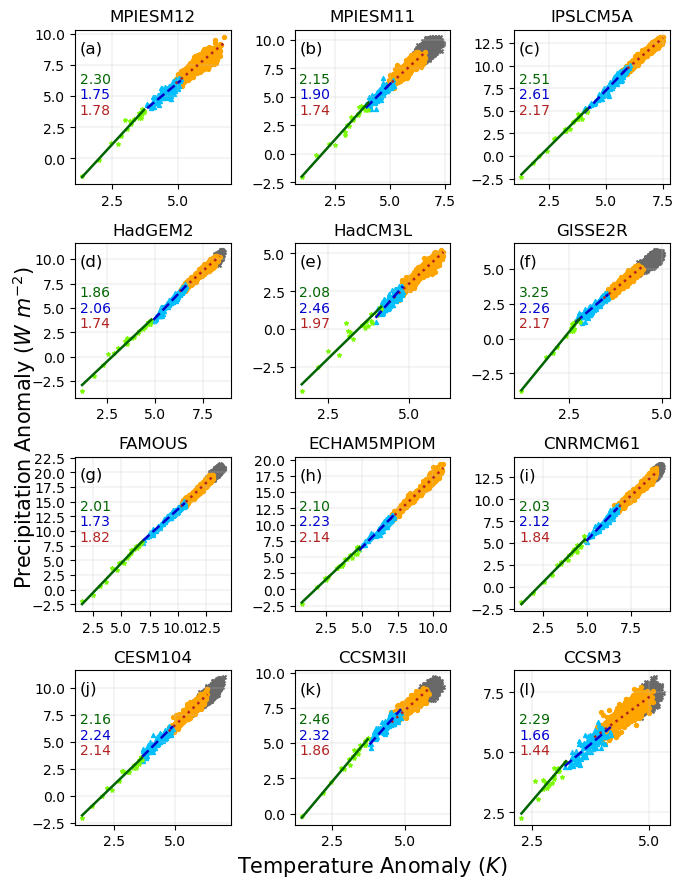

In [20]:
# Plot Precipitation Anomaly VS Temperature Anomaly Graph For All 12 Models
Fig = pyplot.figure(figsize=(7.48,9.28))
Axes = Fig.subplots(4,3, sharex=False, sharey=False)
Precip_1_21_151_Slopes = numpy.zeros((12,3))
Precip_1_21_151_Error_Bars = numpy.zeros((12,3))
i = 0
j = -1
Count = -1
for Model in list(Model_List):
    if j < 2:
        j += 1
    else:
        j = 0
        i += 1
    Count += 1
#    Axes = Fig.add_subplot(4,3, Count)
#
# Open Temperature Control and Temperature 4x Files Using Function
    Temp_Control, Years_Control, Temp_4x, Years_4x = Open_Temp_Files(Temp_Files, Model)
#
# Create Smoothen Temperature 4x and Control Lines Using Function
    Temp_Control_Smooth = Temp_Smooth(Temp_Control, Years_Control, Temp_4x, Years_4x, Model)
#
# Calculate Temperature Anomaly
    Temp_Anomaly = Temp_4x - Temp_Control_Smooth
#
# Open Precipitation Control and Precipitation 4x Files Using Function
    Precip_Control, Years_Control, Precip_4x, Years_4x = Open_Precip_Files(Precip_Files, Model)
#
# Create Smoothen Precipitation 4x and Control Lines Using Function
    Precip_Control_Smooth = Precip_Smooth(Precip_Control, Years_Control, Precip_4x, Years_4x, Model)
#
# Calculate Precipitation Anomaly
    Precip_Control =  Precip_Control * L_Vapour
    Precip_Anomaly = (Precip_4x - Precip_Control_Smooth) * L_Vapour
    if Model=="CCSM3II":
        Precip_Anomaly = Precip_Anomaly * 1000
#
# Calculate Correlation and Standard Deviations
    PI_Len = numpy.min([len(Temp_Control),len(Precip_Control)])
    Precip_Corr = Corr_IgnoreNaN(Temp_Control[:PI_Len],Precip_Control[:PI_Len])
    Precip_Std_x = float(numpy.std(Temp_Control))
    Precip_Std_y = float(numpy.std(Precip_Control))
#
#
# Plot Precipitation Anomaly VS Temperature Anomaly
    Axes[i][j].set_title(Model, fontsize=12)
    Axes[i][j].set_xticks(numpy.arange(0,15,2.5))
    Axes[i][j].set_yticks(numpy.arange(-5,25,2.5))
    Axes[i][j].grid('grid', linestyle="-", linewidth=0.25, color='silver')
#    pyplot.xlim(0,15)
#    pyplot.ylim(-4,22.5)
#
# Plot Points For Precipitation Anomaly VS Temeprature Anomaly For 1001-End Years
    Years_1001_End = range(1001,len(Temp_Anomaly))
    Axes[i][j].scatter(Temp_Anomaly[Years_1001_End], Precip_Anomaly[Years_1001_End], c='dimgray', marker='x', s=8)
#
# Calculate and Plot New York Linear Regression For Precipitation Anomaly VS Temeprature Anomaly For 151-1000 Years
    Years_151_1000 = range(151,1000)
    Precip_151_1000_Slope, Precip_151_1000_Intercept, Precip_151_1000_Error_Bar, Precip_151_1000_Predictions = \
    New_York_Reg(Temp_Anomaly[Years_151_1000], Precip_Anomaly[Years_151_1000], Precip_Corr, Precip_Std_x, Precip_Std_y)
    Axes[i][j].scatter(Temp_Anomaly[Years_151_1000], Precip_Anomaly[Years_151_1000], c='orange', marker='o', s=8)
    Axes[i][j].plot(Precip_151_1000_Predictions[0], Precip_151_1000_Predictions[1], c='firebrick', linewidth=1.8, \
    linestyle=':', label='151-1000')
    Axes[i][j].text(0.03, 0.48, str("%2.2f" % Precip_151_1000_Slope), ha='left', va='center', \
    transform=Axes[i][j].transAxes, fontdict={'size':10},color='firebrick')
#
# Calculate and Plot New York Linear Regression For Precipitation Anomaly VS Temeprature Anomaly For 21-150 Years
    Years_21_150 = range(21,150)
    Precip_21_150_Slope, Precip_21_150_Intercept, Precip_21_150_Error_Bar, Precip_21_150_Predictions = \
    New_York_Reg(Temp_Anomaly[Years_21_150], Precip_Anomaly[Years_21_150], Precip_Corr, Precip_Std_x, Precip_Std_y)
    Axes[i][j].scatter(Temp_Anomaly[Years_21_150], Precip_Anomaly[Years_21_150], c='deepskyblue', marker='^', s=8)
    Axes[i][j].plot(Precip_21_150_Predictions[0], Precip_21_150_Predictions[1], c='mediumblue', linewidth=1.8, \
    linestyle='--', label='21-150')
    Axes[i][j].text(0.03, 0.58, str("%2.2f" % Precip_21_150_Slope), ha='left', va='center', \
    transform=Axes[i][j].transAxes, fontdict={'size':10},color='mediumblue')
#
# Calculate and Plot New York Linear Regression For Precipitation Anomaly VS Temeprature Anomaly For 1-20 Years
    Years_1_20 = range(20)
    Precip_1_20_Slope, Precip_1_20_Intercept, Precip_1_20_Error_Bar, Precip_1_20_Predictions = \
    New_York_Reg(Temp_Anomaly[Years_1_20], Precip_Anomaly[Years_1_20], Precip_Corr, Precip_Std_x, Precip_Std_y)
    Axes[i][j].scatter(Temp_Anomaly[Years_1_20], Precip_Anomaly[Years_1_20], c='lawngreen', marker='*', s=8)
    Axes[i][j].plot(Precip_1_20_Predictions[0], Precip_1_20_Predictions[1], c='darkgreen', linewidth=1.8, \
    linestyle='-', label='1-20')
    Axes[i][j].text(0.03, 0.68, str("%2.2f" % Precip_1_20_Slope), ha='left', va='center', \
    transform=Axes[i][j].transAxes, fontdict={'size':10},color='darkgreen')
#
# Add Alphabet Label
    Alphabets = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l"]
    Axes[i][j].text(0.03, 0.88, str("("+Alphabets[Count]+")"), ha='left', va='center', \
    transform=Axes[i][j].transAxes, fontdict={'size':12},color='black')
#
# Store Regression Slopes Into Array
    Precip_1_21_151_Slopes[Count][0] = Precip_1_20_Slope
    Precip_1_21_151_Slopes[Count][1] = Precip_21_150_Slope
    Precip_1_21_151_Slopes[Count][2] = Precip_151_1000_Slope
    Precip_1_21_151_Error_Bars[Count][0] = Precip_1_20_Error_Bar
    Precip_1_21_151_Error_Bars[Count][1] = Precip_21_150_Error_Bar
    Precip_1_21_151_Error_Bars[Count][2] = Precip_151_1000_Error_Bar
#
# Set Axes Labels
Fig.add_subplot(111, frameon=False)
# Hide Tick and Tick Label of the Big Axis
pyplot.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
pyplot.xlabel('Temperature Anomaly ($K$)', fontsize=15)
pyplot.ylabel('Precipitation Anomaly ($W$ $m^{-2}$)', fontsize=15)
pyplot.tight_layout()
#Fig.savefig('Hydrological_Sensitivity_12.png', bbox_inches='tight')
Fig.savefig('figures/FIGURE_1.eps', bbox_inches='tight')

## Figure S1

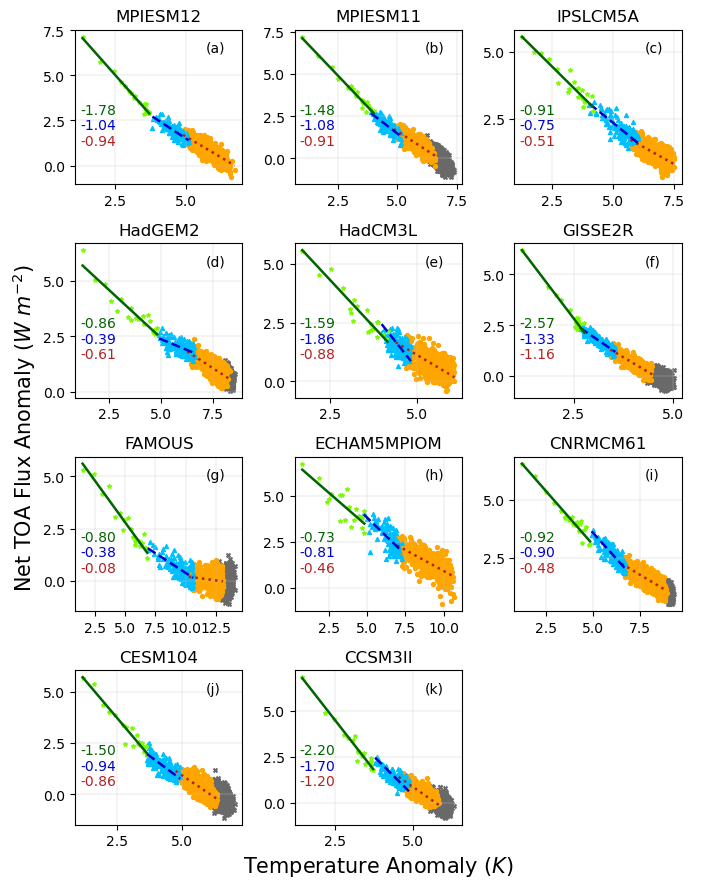

In [21]:
# Plot Net TOA Flux Anomaly VS Temperature Anomaly Graph For All 12 Models
Fig = pyplot.figure(figsize=(7.48,9.28))
Axes = Fig.subplots(4,3, sharex=False, sharey=False)
Net_TOA_1_21_151_Slopes = numpy.zeros((12,3))
Net_TOA_1_21_151_Error_Bars = numpy.zeros((12,3))
i = 0
j = -1
Count = -1
for Model in list(Model_List):
    if j < 2:
        j += 1
    else:
        j = 0
        i += 1
    Count += 1
#    Axes = Fig.add_subplot(4,3, Count)
#
# Open Temperature Control and Temperature 4x Files Using Function
    Temp_Control, Years_Control, Temp_4x, Years_4x = Open_Temp_Files(Temp_Files, Model)
#
# Create Smoothen Temperature 4x and Control Lines Using Function
    Temp_Control_Smooth = Temp_Smooth(Temp_Control, Years_Control, Temp_4x, Years_4x, Model)
#
# Calculate Temperature Anomaly
    Temp_Anomaly = Temp_4x - Temp_Control_Smooth
#
# Open Net TOA Flux Control and Net TOA Flux 4x Files Using Function
    Net_TOA_Control, Years_Control, Net_TOA_4x, Years_4x = Open_Net_TOA_Files(Net_TOA_Files, Model)
#
# Create Smoothen Net TOA Flux 4x and Control Lines Using Function
    Net_TOA_Control_Smooth = Net_TOA_Smooth(Net_TOA_Control, Years_Control, Net_TOA_4x, Years_4x, Model)
#
# Calculate Net TOA Flux Anomaly
    Net_TOA_Anomaly = Net_TOA_4x - Net_TOA_Control_Smooth
#
# Calculate Correlation and Standard Deviations
    if Model != "CCSM3":
        PI_Len = numpy.min([len(Temp_Control),len(Net_TOA_Control)])
        Net_TOA_Corr = Corr_IgnoreNaN(Temp_Control[:PI_Len],Net_TOA_Control[:PI_Len])
        Net_TOA_Std_x = float(numpy.std(Temp_Control))
        Net_TOA_Std_y = float(numpy.std(Net_TOA_Control))
#
#
# Plot Net TOA Flux Anomaly VS Temperature Anomaly
        Axes[i][j].set_title(Model, fontsize=12)
        Axes[i][j].set_xticks(numpy.arange(0,15,2.5))
        Axes[i][j].set_yticks(numpy.arange(-5,25,2.5))
        Axes[i][j].grid('grid', linestyle="-", linewidth=0.25, color='silver')
#    pyplot.xlim(0,15)
#    pyplot.ylim(-4,22.5)
#
# Plot Points For Net TOA Flux Anomaly VS Temeprature Anomaly For 1001-End Years
        Years_1001_End = range(1001,len(Temp_Anomaly))
        Axes[i][j].scatter(Temp_Anomaly[Years_1001_End], Net_TOA_Anomaly[Years_1001_End], c='dimgray', marker='x', s=8)
#
# Calculate and Plot New York Linear Regression For Net TOA Flux Anomaly VS Temeprature Anomaly For 151-1000 Years
        Years_151_1000 = range(151,1000)
        Net_TOA_151_1000_Slope, Net_TOA_151_1000_Intercept, Net_TOA_151_1000_Error_Bar, Net_TOA_151_1000_Predictions = \
        New_York_Reg(Temp_Anomaly[Years_151_1000], Net_TOA_Anomaly[Years_151_1000], Net_TOA_Corr, Net_TOA_Std_x, Net_TOA_Std_y)
        Axes[i][j].scatter(Temp_Anomaly[Years_151_1000], Net_TOA_Anomaly[Years_151_1000], c='orange', marker='o', s=8)
        Axes[i][j].plot(Net_TOA_151_1000_Predictions[0], Net_TOA_151_1000_Predictions[1], c='firebrick', linewidth=1.8, \
        linestyle=':', label='151-1000')
        Axes[i][j].text(0.03, 0.28, str("%2.2f" % Net_TOA_151_1000_Slope), ha='left', va='center', \
        transform=Axes[i][j].transAxes, fontdict={'size':10},color='firebrick')
#
# Calculate and Plot New York Linear Regression For Net TOA Flux Anomaly VS Temeprature Anomaly For 21-150 Years
        Years_21_150 = range(21,150)
        Net_TOA_21_150_Slope, Net_TOA_21_150_Intercept, Net_TOA_21_150_Error_Bar, Net_TOA_21_150_Predictions = \
        New_York_Reg(Temp_Anomaly[Years_21_150], Net_TOA_Anomaly[Years_21_150], Net_TOA_Corr, Net_TOA_Std_x, Net_TOA_Std_y)
        Axes[i][j].scatter(Temp_Anomaly[Years_21_150], Net_TOA_Anomaly[Years_21_150], c='deepskyblue', marker='^', s=8)
        Axes[i][j].plot(Net_TOA_21_150_Predictions[0], Net_TOA_21_150_Predictions[1], c='mediumblue', linewidth=1.8, \
        linestyle='--', label='21-150')
        Axes[i][j].text(0.03, 0.38, str("%2.2f" % Net_TOA_21_150_Slope), ha='left', va='center', \
        transform=Axes[i][j].transAxes, fontdict={'size':10},color='mediumblue')
#
# Calculate and Plot New York Linear Regression For Net TOA Flux Anomaly VS Temeprature Anomaly For 1-20 Years
        Years_1_20 = range(20)
        Net_TOA_1_20_Slope, Net_TOA_1_20_Intercept, Net_TOA_1_20_Error_Bar, Net_TOA_1_20_Predictions = \
        New_York_Reg(Temp_Anomaly[Years_1_20], Net_TOA_Anomaly[Years_1_20], Net_TOA_Corr, Net_TOA_Std_x, Net_TOA_Std_y)
        Axes[i][j].scatter(Temp_Anomaly[Years_1_20], Net_TOA_Anomaly[Years_1_20], c='lawngreen', marker='*', s=8)
        Axes[i][j].plot(Net_TOA_1_20_Predictions[0], Net_TOA_1_20_Predictions[1], c='darkgreen', linewidth=1.8, \
        linestyle='-', label='1-20')
        Axes[i][j].text(0.03, 0.48, str("%2.2f" % Net_TOA_1_20_Slope), ha='left', va='center', \
        transform=Axes[i][j].transAxes, fontdict={'size':10},color='darkgreen')
#
# Add Alphabet Label
    Alphabets = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l"]
    if Count != 11:
        Axes[i][j].text(0.78, 0.88, str("("+Alphabets[Count]+")"), ha='left', va='center', \
        transform=Axes[i][j].transAxes, fontdict={'size':10},color='black')
    if Count == 11:
        Axes[i][j].set(visible=False)
#
# Store Regression Slopes Into Array
    if Count != 11:
        Net_TOA_1_21_151_Slopes[Count][0] = Net_TOA_1_20_Slope
        Net_TOA_1_21_151_Slopes[Count][1] = Net_TOA_21_150_Slope
        Net_TOA_1_21_151_Slopes[Count][2] = Net_TOA_151_1000_Slope
        Net_TOA_1_21_151_Error_Bars[Count][0] = Net_TOA_1_20_Error_Bar
        Net_TOA_1_21_151_Error_Bars[Count][1] = Net_TOA_21_150_Error_Bar
        Net_TOA_1_21_151_Error_Bars[Count][2] = Net_TOA_151_1000_Error_Bar
    else:
        Net_TOA_1_21_151_Slopes[Count][0] = numpy.nan
        Net_TOA_1_21_151_Slopes[Count][1] = numpy.nan
        Net_TOA_1_21_151_Slopes[Count][2] = numpy.nan
        Net_TOA_1_21_151_Error_Bars[Count][0] = numpy.nan
        Net_TOA_1_21_151_Error_Bars[Count][1] = numpy.nan
        Net_TOA_1_21_151_Error_Bars[Count][2] = numpy.nan
#
# Set Axes Labels
Fig.add_subplot(111, frameon=False)
# Hide Tick and Tick Label of the Big Axis
pyplot.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
pyplot.xlabel('Temperature Anomaly ($K$)', fontsize=15)
pyplot.ylabel('Net TOA Flux Anomaly ($W$ $m^{-2}$)', fontsize=15)
pyplot.tight_layout()
#Fig.savefig('Climate_Sensitivity_11.png', bbox_inches='tight')
Fig.savefig('figures/FIGURE_S1.eps', bbox_inches='tight')

## Regression Slopes Plots

In [22]:
# Create Function to Calculate If Slope Significantly Different Than 21-150 Slope Or Not
def Slope_Compare(Slopes, Error_Bars, Time_Periods, Model_Index, Var, Axes, i):
    elw = 2.5
    msp = 0.050
    # Compare Between First Slope and 21-150 Slope
    Slope_1_2 = numpy.array([Slopes[0], Slopes[1]])
#    Error_Bar_1_2 = numpy.array([Error_Bars[0], Error_Bars[1]])
    Time_Period_1_2 = [Time_Periods[0], Time_Periods[1]]
    k = Model_Index
    Axes[i].plot([0.830 + k*msp, 1.830 + k*msp], Slope_1_2, color="black", linewidth=0.8)
    print (Error_Bars[0])
    if Slopes[0]-Error_Bars[0] > Slopes[1]+Error_Bars[1]:
        Compare_1_2 = "Above"
        if Var == "Precip":
            Axes[i].errorbar(0.830 + k*msp, Slopes[0], yerr=Error_Bars[0], color="limegreen", \
            fmt='none', markersize=3, elinewidth=elw)
#, uplims=True, lolims=True
        elif Var == "Net TOA":
            Axes[i].errorbar(0.830 + k*msp, Slopes[0], yerr=Error_Bars[0], color="red", \
            fmt='none', markersize=3, elinewidth=elw)
    elif Slopes[0]+Error_Bars[0] < Slopes[1]-Error_Bars[1]:
        Compare_1_2 = "Below"
        if Var == "Precip":
            Axes[i].errorbar(0.830 + k*msp, Slopes[0], yerr=Error_Bars[0], color="red", \
            fmt='none', markersize=3, elinewidth=elw)
        elif Var == "Net TOA":
            Axes[i].errorbar(0.830 + k*msp, Slopes[0], yerr=Error_Bars[0], color="limegreen", \
            fmt='none', markersize=3, elinewidth=elw)
    else:
        Compare_1_2 = "Not Signif."
        Axes[i].errorbar(0.830 + k*msp, Slopes[0], yerr=Error_Bars[0], color="dimgray", \
        fmt='none', markersize=3, elinewidth=elw)
    Axes[i].errorbar(1.830 + k*msp, Slopes[1], yerr=Error_Bars[1], color="dimgray", \
    fmt='none', markersize=3, elinewidth=elw)
#
# Compare Between Third Slope and 21-150 Slope
    Slope_2_3 = numpy.array([Slopes[1], Slopes[2]])
#    Error_Bar_2_3 = numpy.array([Error_Bars[1], Error_Bars[2]])
    Time_Period_2_3 = [Time_Periods[1], Time_Periods[2]]
    Axes[i].plot([1.830 + k*msp, 2.830 + k*msp], Slope_2_3, color="black", linewidth=0.8)
    if Slopes[2]-Error_Bars[2] > Slopes[1]+Error_Bars[1]:
        Compare_3_2 = "Above"
        if Var == "Precip":
            Axes[i].errorbar(2.830 + k*msp, Slopes[2], yerr=numpy.abs(Error_Bars[2]), color="limegreen", \
            fmt='none', markersize=3, elinewidth=elw) # was: markersize 3
        elif Var == "Net TOA":
            Axes[i].errorbar(2.830 + k*msp, Slopes[2], yerr=numpy.abs(Error_Bars[2]), color="red", \
            fmt='none', markersize=3, elinewidth=elw)
    elif Slopes[2]+Error_Bars[2] < Slopes[1]-Error_Bars[1]:
        Compare_3_2 = "Below"
        if Var == "Precip":
            Axes[i].errorbar(2.830 + k*msp, Slopes[2], yerr=numpy.abs(Error_Bars[2]), color="red", \
            fmt='none', markersize=3, elinewidth=elw)
        elif Var == "Net TOA":
            Axes[i].errorbar(2.830 + k*msp, Slopes[2], yerr=numpy.abs(Error_Bars[2]), color="limegreen", \
            fmt='none', markersize=3, elinewidth=elw)
    else:
        Compare_3_2 = "Not Signif."
        Axes[i].errorbar(2.830 + k*msp, Slopes[2], yerr=numpy.abs(Error_Bars[2]), color="dimgray", \
        fmt='none', markersize=3, elinewidth=elw)
#
# Edit x Axis Labels
#    pyplot.xticks(numpy.array(range(len(Time_Periods)))+1, Time_Periods)
#
# Return Results
    return (Compare_1_2, Compare_3_2)

In [23]:
# Create Function to Reorder Models According to 21-150 Slopes
def Slope_Reorder(Slopes, Error_Bars, Model_List):
# Create 21-150 Years Slopes List
    Slopes_21_150 = []
    for k in range(12):
        Slopes_21_150.append(Slopes[k][1])
# Sort Slopes, Confidence Intervals and Models According to 21-150 Slopes
    Slopes_Sorted = [Slope for _, Slope in sorted(zip(Slopes_21_150, Slopes))]
    Error_Bars_Sorted = [Error_Bar for _, Error_Bar in sorted(zip(Slopes_21_150, Error_Bars))]
    Model_Sorted = [Model for _, Model in sorted(zip(Slopes_21_150, Model_List))]
# Return Results
    return (Slopes_Sorted, Error_Bars_Sorted, Model_Sorted)

## Figure 2

In [24]:
Precip_1_21_151_Slopes

array([[2.30025397, 1.7470528 , 1.77654175],
       [2.14878243, 1.89665645, 1.74058626],
       [2.50692102, 2.60843875, 2.16583736],
       [1.85860748, 2.05891452, 1.74088342],
       [2.08344487, 2.45846809, 1.96897908],
       [3.24633947, 2.259853  , 2.1678214 ],
       [2.00894792, 1.72722735, 1.81875033],
       [2.10342482, 2.22818205, 2.13942438],
       [2.03168778, 2.11523752, 1.83964864],
       [2.16214781, 2.23821408, 2.13977271],
       [2.45982122, 2.3190245 , 1.85932313],
       [2.29304299, 1.66257113, 1.44025792]])

In [25]:
Precip_1_21_151_Error_Bars

array([[0.10301654, 0.10002541, 0.02695835],
       [0.08148765, 0.10927724, 0.02622894],
       [0.07208876, 0.0550831 , 0.02077051],
       [0.04652478, 0.0442401 , 0.01623029],
       [0.14755992, 0.25635979, 0.04127528],
       [0.20962733, 0.11234428, 0.04130464],
       [0.04825217, 0.03178156, 0.01656913],
       [0.04683039, 0.05952544, 0.00976219],
       [0.06610267, 0.06931681, 0.01690133],
       [0.0932314 , 0.08946276, 0.03807664],
       [0.1337395 , 0.12452544, 0.03127419],
       [0.33130598, 0.15068675, 0.03193657]])

In [26]:
Net_TOA_1_21_151_Slopes

array([[-1.78079254, -1.03597305, -0.93680532],
       [-1.47540994, -1.0837206 , -0.90902402],
       [-0.91025586, -0.74577452, -0.51383312],
       [-0.8611141 , -0.38770769, -0.60673099],
       [-1.58623564, -1.86198116, -0.87786251],
       [-2.57449558, -1.33100566, -1.15753913],
       [-0.79848226, -0.37683889, -0.078403  ],
       [-0.72968189, -0.81183068, -0.46093749],
       [-0.92325253, -0.89656837, -0.48429654],
       [-1.50041343, -0.94246835, -0.85657789],
       [-2.19543874, -1.70016186, -1.1955304 ],
       [        nan,         nan,         nan]])

In [27]:
Net_TOA_1_21_151_Error_Bars

array([[0.09157758, 0.08531706, 0.02379039],
       [0.07082637, 0.09449365, 0.02405608],
       [0.06164677, 0.04541733, 0.01781796],
       [0.05663239, 0.05024941, 0.01939275],
       [0.13966002, 0.45078182, 0.05167905],
       [0.14849992, 0.07890894, 0.0292856 ],
       [0.04157559, 0.02732487, 0.01390224],
       [0.13707271, 0.11820819, 0.02442503],
       [0.05955786, 0.06435263, 0.01419681],
       [0.08833359, 0.08368687, 0.03670729],
       [0.12341847, 0.13417577, 0.032689  ],
       [       nan,        nan,        nan]])

0.3313059834593645
0.048252173931979905
0.1030165390884079
0.08148764661261673
0.04652478387521583
0.06610267068382121
0.04683038537018491
0.0932314005452768
0.20962732558473496
0.13373949544930044
0.1475599185801405
0.07208876295314337
0.13966002494160284
0.12341847068723046
0.14849991761989398
0.07082636789449348
0.09157757610435456
0.08833359423668483
0.059557856686562084
0.1370727057441543
0.06164676657660877
0.056632392721076036
0.041575592549213995
nan


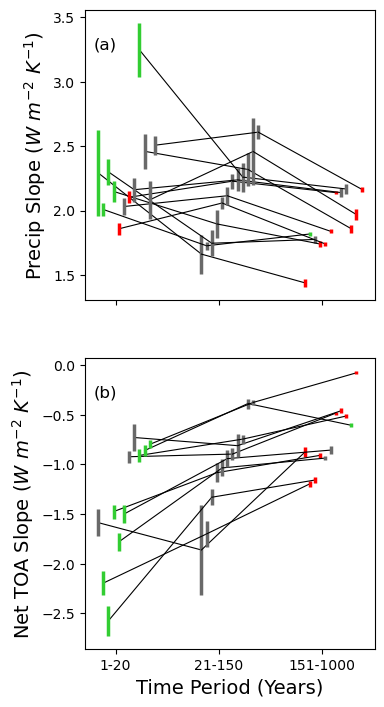

In [28]:
Fig = pyplot.figure(figsize=(3.74,8.30))
Axes = Fig.subplots(2,1, sharex=True, sharey=False)
for i in range(2):
#
# Plot Linear Regression Slopes For Precip Anomaly VS Temeprature Anomaly By Time Period
#    Axes = Fig.add_subplot(2,1, Count)
    if i == 0:
        Time_Periods = ["1-20", "21-150", "151-1000"]
        # Reorder Models According to 21-150 Slopes
        Precip_1_21_151_Slopes_Sorted, Precip_1_21_151_Error_Bars_Sorted, Model_Sorted = \
        Slope_Reorder(Precip_1_21_151_Slopes, Precip_1_21_151_Error_Bars, Model_List)
        # Plot Lines and Error Bars
        for k in range(len(Precip_1_21_151_Slopes_Sorted)):
            Compare_1_21, Compare_151_21 = Slope_Compare(Precip_1_21_151_Slopes_Sorted[k], \
            Precip_1_21_151_Error_Bars_Sorted[k], Time_Periods, k, "Precip", Axes, i)
        # Formatting
        #pyplot.title('Regression Slopes For Precip Anomaly VS Temp Anomaly by Time Period', fontsize=18)
        Axes[i].text(0.03, 0.88, str("(a)"), ha='left', va='center', transform=Axes[i].transAxes, \
        fontdict={'size':12},color='black')
#        Axes.set_xlabel('Time Period (Years)', fontsize=14)
        Axes[i].set_ylabel('Precip Slope ($W$ $m^{-2}$ $K^{-1}$)', fontsize=14)
#        Axes[i].set_yticks(numpy.arange(0,5,0.5))
        #Axes[i].grid('grid', linestyle="-", linewidth=0.8, color='silver')
#        Axes[i].ylim(1.2, 3.5)
#
#
# Plot Linear Regression Slopes For Net TOA Anomaly VS Temeprature Anomaly By Time Period
    elif i == 1:
        Time_Periods = ["1-20", "21-150", "151-1000"]
        # Reorder Models According to 21-150 Slopes
        Net_TOA_1_21_151_Slopes_Sorted, Net_TOA_1_21_151_Error_Bars_Sorted, Model_Sorted = \
        Slope_Reorder(Net_TOA_1_21_151_Slopes, Net_TOA_1_21_151_Error_Bars, Model_List)
        # Plot Lines and Error Bars
        for k in range(len(Net_TOA_1_21_151_Slopes_Sorted)):
            Compare_1_21, Compare_151_21 = Slope_Compare(Net_TOA_1_21_151_Slopes_Sorted[k], \
            Net_TOA_1_21_151_Error_Bars_Sorted[k], Time_Periods, k, "Net TOA", Axes, i)
        # Formatting
        #Axes[i].set_title('Regression Slopes For Net TOA Anomaly VS Temp Anomaly by Time Period', fontsize=18)
        Axes[i].text(0.03, 0.88, str("(b)"), ha='left', va='center', transform=Axes[i].transAxes, \
        fontdict={'size':12},color='black')
        Axes[i].set_xlabel('Time Period (Years)', fontsize=14)
        Axes[i].set_ylabel('Net TOA Slope ($W$ $m^{-2}$ $K^{-1}$)', fontsize=14)
#        Axes[i].set_xticks(['1-20', '21-150', '151-1000'])
#        pyplot.xticks([r for r in range(3)], [r'1-20', r'21-150', r'151-1000'])
        pyplot.xticks(numpy.array(range(len(Time_Periods)))+1, Time_Periods)
#        Axes[i].set_yticks(numpy.arange(-5,0,0.5))
        #Axes[i].grid('grid', linestyle="-", linewidth=0.8, color='silver')
#        pyplot.ylim(-2.8, 0.0)
#
Fig.savefig('figures/FIGURE_2.eps', bbox_inches='tight')
Fig.savefig('figures/FIGURE_2.pdf', bbox_inches='tight')

In [30]:
# Create DataFrame With Comparison Between Slopes
for i in range(len(Model_Sorted)):
    if Model_Sorted[i] == "CCSM3":
        Net_TOA_1_21_Compare[i] = "No Data"
        Net_TOA_151_21_Compare[i] = "No Data"
Net_TOA_1_21_151_Compare = pandas.DataFrame({"Model": Model_Sorted, "1-20 VS 21-150": Net_TOA_1_21_Compare, \
"151-1000 VS 21-150": Net_TOA_151_21_Compare})
Net_TOA_1_21_151_Compare

,Model,1-20 VS 21-150,151-1000 VS 21-150
0,HadCM3L,Not Signif.,Above
1,CCSM3II,Below,Above
2,GISSE2R,Below,Above
3,MPIESM11,Below,Above
4,MPIESM12,Below,Not Signif.
5,CESM104,Below,Not Signif.
6,CNRMCM61,Not Signif.,Above
7,ECHAM5MPIOM,Not Signif.,Above
8,IPSLCM5A,Below,Above
9,HadGEM2,Below,Below


In [31]:
# Create DataFrame With Comparison Between Slopes
Precip_1_21_151_Compare = pandas.DataFrame({"Model": Model_Sorted, "1-20 VS 21-150": Precip_1_21_Compare, \
"151-1000 VS 21-150": Precip_151_21_Compare})
Precip_1_21_151_Compare

,Model,1-20 VS 21-150,151-1000 VS 21-150
0,HadCM3L,Above,Below
1,CCSM3II,Above,Above
2,GISSE2R,Above,Not Signif.
3,MPIESM11,Above,Below
4,MPIESM12,Below,Below
5,CESM104,Not Signif.,Below
6,CNRMCM61,Below,Below
7,ECHAM5MPIOM,Not Signif.,Not Signif.
8,IPSLCM5A,Above,Not Signif.
9,HadGEM2,Not Signif.,Below


In [32]:
# Create DataFrame With Comparison Between Slopes
for i in range(len(Model_Sorted)):
    if Model_Sorted[i] == "CCSM3":
        Net_TOA_1_21_Compare[i] = "No Data"
        Net_TOA_151_21_Compare[i] = "No Data"
Net_TOA_1_21_151_Compare = pandas.DataFrame({"Model": Model_Sorted, "1-20 VS 21-150": Net_TOA_1_21_Compare, \
"151-1000 VS 21-150": Net_TOA_151_21_Compare})
Net_TOA_1_21_151_Compare

,Model,1-20 VS 21-150,151-1000 VS 21-150
0,HadCM3L,Not Signif.,Above
1,CCSM3II,Below,Above
2,GISSE2R,Below,Above
3,MPIESM11,Below,Above
4,MPIESM12,Below,Not Signif.
5,CESM104,Below,Not Signif.
6,CNRMCM61,Not Signif.,Above
7,ECHAM5MPIOM,Not Signif.,Above
8,IPSLCM5A,Below,Above
9,HadGEM2,Below,Below


In [33]:
# Create Net TOA Slopes DataFrame
for i in range(len(Net_TOA_1_21_151_Slopes)):
    if i == 0:
        Net_TOA_Slopes_DF = pandas.DataFrame({Model_List[i]: Net_TOA_1_21_151_Slopes[i]})
    else:
        Net_TOA_Slopes_DF[Model_List[i]] = Net_TOA_1_21_151_Slopes[i]
Net_TOA_Slopes_DF

,MPIESM12,MPIESM11,IPSLCM5A,HadGEM2,HadCM3L,GISSE2R,FAMOUS,ECHAM5MPIOM,CNRMCM61,CESM104,CCSM3II,CCSM3
0,-1.780793,-1.475410,-0.910256,-0.861114,-1.586236,-2.574496,-0.798482,-0.729682,-0.923253,-1.500413,-2.195439,NaN
1,-1.035973,-1.083721,-0.745775,-0.387708,-1.861981,-1.331006,-0.376839,-0.811831,-0.896568,-0.942468,-1.700162,NaN
2,-0.936805,-0.909024,-0.513833,-0.606731,-0.877863,-1.157539,-0.078403,-0.460937,-0.484297,-0.856578,-1.195530,NaN


In [34]:
# Create Precip Slopes DataFrame
for i in range(len(Precip_1_21_151_Slopes)):
    if i == 0:
        Precip_Slopes_DF = pandas.DataFrame({Model_List[i]: Precip_1_21_151_Slopes[i]})
    else:
        Precip_Slopes_DF[Model_List[i]] = Precip_1_21_151_Slopes[i]
Precip_Slopes_DF

,MPIESM12,MPIESM11,IPSLCM5A,HadGEM2,HadCM3L,GISSE2R,FAMOUS,ECHAM5MPIOM,CNRMCM61,CESM104,CCSM3II,CCSM3
0,2.300254,2.148782,2.506921,1.858607,2.083445,3.246339,2.008948,2.103425,2.031688,2.162148,2.459821,2.293043
1,1.747053,1.896656,2.608439,2.058915,2.458468,2.259853,1.727227,2.228182,2.115238,2.238214,2.319025,1.662571
2,1.776542,1.740586,2.165837,1.740883,1.968979,2.167821,1.818750,2.139424,1.839649,2.139773,1.859323,1.440258


In [36]:
# Create New CSV Files
#numpy.savetxt("./"+"CSV/"+"Net_TOA_Slopes.csv", Net_TOA_1_21_151_Slopes, delimiter=',')
Filename_1 = "./"+"CSV/"+"Net_TOA_Slopes.csv"
Net_TOA_Slopes_DF.to_csv(Filename_1)
Filename_2 = "./"+"CSV/"+"Precip_Slopes.csv"
Precip_Slopes_DF.to_csv(Filename_2)